In [1]:
import sklearn

In [14]:
import pandas as pd
import numpy as np
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nelson\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
#df = pd.read_csv("Peter_Obi.csv")
df_t = pd.read_csv("data/election_tinubu.csv")
df_a = pd.read_csv("data/election_atiku.csv")
df_p = pd.read_csv("data/election_peter_obi.csv")


In [16]:
# Clean text
import regex as re
import emoji
def cleanText(text):
    text = re.sub(r'@[A-Za-z0-9]+', "", text) #removes @mentions
    text = re.sub(r'#', '', text) # remove hashtags
    text = re.sub(r'RT[\s]+', '', text) #Remove retweets
    text = re.sub(r'https?:\/\/\S+', '', text) # remove hyper link
    text = re.sub(r'[^\w\s]', '', text) #remove punctuation
    text = emoji.replace_emoji(text)
    return text

df_a['Tweets'] = df_a['Tweets'].apply(cleanText)
df_t['Tweets'] = df_t['Tweets'].apply(cleanText)
df_p['Tweets'] = df_p['Tweets'].apply(cleanText)


In [17]:
# Create subjectivity and polarity
# Subjectivity tells how subjective or opinionated the text is

# def get_subjectivity(text):
#     return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

# Create new columns
# df['Subjectivity'] = df['Tweets'].apply(get_subjectivity)
df_a['Polarity'] = df_a['Tweets'].apply(get_polarity)
df_t['Polarity'] = df_t['Tweets'].apply(get_polarity)
df_p['Polarity'] = df_p['Tweets'].apply(get_polarity)


In [18]:
# word cloud
def create_wordcloud(data, feature):
    words = ' '.join([t for t in data[feature]])
    wordCloud = WordCloud(width= 500, height=400).generate(words)
    plt.imshow(wordCloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.show()


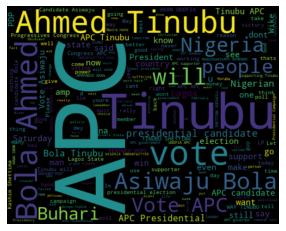

In [19]:
# word cloud for tweets on tinubu
create_wordcloud(data=df_t, feature='Tweets')

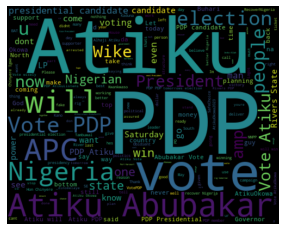

In [20]:
#atiku
create_wordcloud(data=df_a, feature='Tweets')

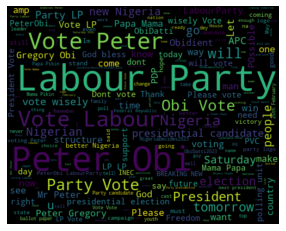

In [21]:
#peter obi
create_wordcloud(data=df_p, feature='Tweets')

In [22]:
# function to compute negative, neutral, and positive sentiment score

def get_analysis(score):
    if score < 0:
        return "Negative"
    elif score == 0:
        return 'Neutral'
    else:
        return "Positive"
    
df_p['Analysis'] = df_p['Polarity'].apply(get_analysis)
df_t['Analysis'] = df_t['Polarity'].apply(get_analysis)
df_a['Analysis'] = df_a['Polarity'].apply(get_analysis)
#df['Sub_analysis'] = df['Subjectivity'].apply(get_analysis)

In [40]:
df_p['Name'] = "Peter obi"
df_t['Name'] = "Tinubu"
df_a['Name'] = "Atiku"

In [42]:
#plot all three sentiments
final_df = pd.concat([df_a, df_p, df_t])

In [44]:
df_group = final_df.groupby(['Analysis', 'Name']).size().reset_index(name='count')

In [47]:
df_group.head()

,Analysis,Name,count
0,Negative,Atiku,709
1,Negative,Peter obi,1073
2,Negative,Tinubu,1147
3,Neutral,Atiku,1721
4,Neutral,Peter obi,4285


In [52]:
len(df_group)

9

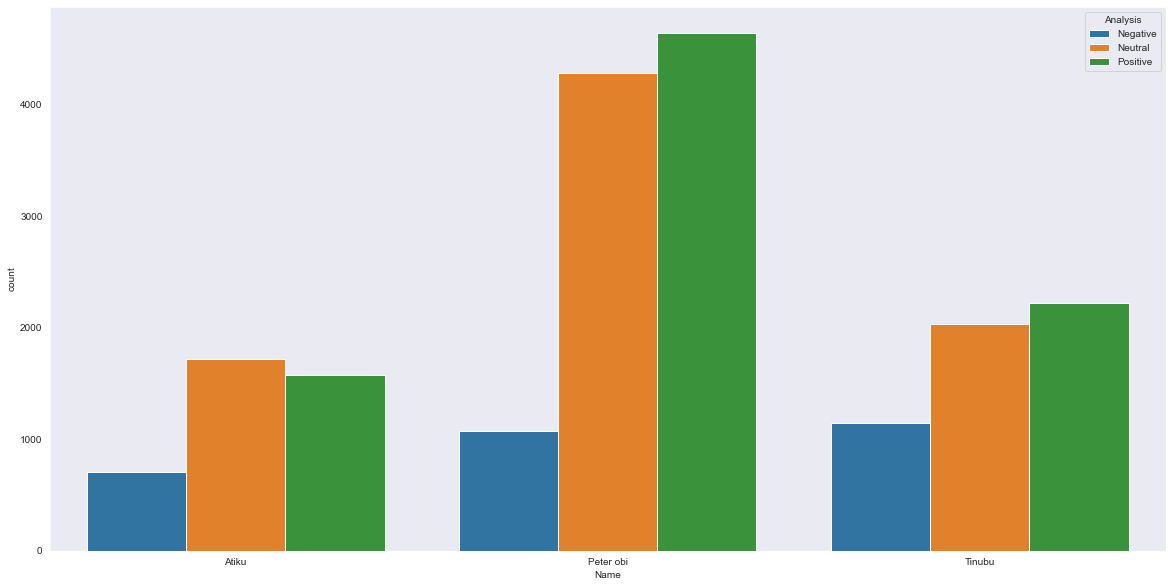

In [57]:
import seaborn as sns

plt.figure(figsize=(20,10))
sns.set_style("dark")
sns.barplot(data = df_group, x='Name', y='count', hue='Analysis', ci='sd')
plt.show()

In [59]:
#function to tokenize, remove stop words, remove punctuation and apply stemming 

def preprocess():
    final_df['Clean_tweet'] = final_df['Tweets'].apply(lambda x: x.split()) #tokenize words
    stop_words = stopwords.words('english')
    additional_words = ['u', 'say', 'if', 'get', 'so', 'as', 'see','we'] #include additional words to stopwords
    stop_words.extend(additional_words)
    stop_words = set(stop_words) # Make stop words unique
    final_df['Clean_tweet'] = final_df['Clean_tweet'].apply(lambda x: [w.lower() for w in x]) #turn words to lowercase
    final_df['Clean_tweet'] = final_df['Clean_tweet'].apply(lambda x: [word for word in x if not word in stop_words]) #Remove stop words from words
    final_df['Clean_tweet'] = final_df['Clean_tweet'].apply(lambda x: [word for word in x if word.isalpha()]) # remove punctuation
    stemmer = PorterStemmer()
    final_df['Clean_tweet'] = final_df['Clean_tweet'].apply(lambda x: [stemmer.stem(w) for w in x]) # Apply stemming to word
    # Combine all text into single sentence 
    final_df['Clean_tweet'] = final_df['Clean_tweet'].apply(lambda x: " ".join(x))

    return final_df


In [60]:
df = preprocess()

In [61]:
# Count vectorizer
from sklearn.feature_extraction.text import CountVectorizer

def feat_extraction(data:pd.DataFrame, feature: str, label:str):
    cv = CountVectorizer(max_features=5000)
    X = cv.fit_transform(data[feature]).toarray()
    lb = LabelEncoder()
    data[label] = lb.fit_transform(data[label])
    y = data[label].values
    return X, y


In [62]:
X, y= feat_extraction(data=df, feature='Clean_tweet', label='Analysis')

In [63]:

def train_test_pred(feature, label, algo):
    train_X, test_X,train_y, test_y=train_test_split(feature, label, test_size=0.3, random_state=2023, stratify=df['Analysis'])
    model = algo.fit(train_X, train_y)
    pred = model.predict(test_X)
    accuracy = accuracy_score(pred, test_y)

    return accuracy

In [64]:
mb = BernoulliNB()
accuracy = train_test_pred(feature=X, label=y, algo=mb)

In [65]:
accuracy

0.7407725321888412

olleh
